In [1]:
import os
import numpy as np
import pandas as pd
pd.set_option('display.expand_frame_repr', False)
import gspread
import matplotlib.pyplot as plt

In [2]:
exps = ['1001_jiuhai_seed-0123']

datasets = ['ogb-molpcba', 'ogb-molhiv', 'ogbg-ppa', 'UPFD', 'SBM-Isolation', 'SBM-Environment', 'RotatedMNIST', 'ColoredMNIST']
algorithms = ['ERM', 'groupDRO', 'IRM', 'deepCORAL', 'DANN', 'DANN-G', 'MLDG', 'FLAG', 'GCL']
models = ['gin', 'mlp', 'gin_10_layers', 'gcn', 'gin_virtual', 'transformer', 'cheb', '3wlgnn']


base_model = {
    'ogb-molpcba': 'gin_virtual', 
    'ogb-molhiv': 'gin_virtual',
    'ogbg-ppa': 'gin_virtual',
    'UPFD': 'cheb',
    'SBM-Isolation': 'cheb',
    'SBM-Environment': 'gin_10_layers',
    'RotatedMNIST': 'cheb',
    'ColoredMNIST': 'cheb',
}

parameter_lists = {
    'IRM': ['1.0', '100.0'],
    'deepCORAL': ['1.0', '10.0'],
    'DANN': ['0.1', '1.0', '10.0'],
    'DANN-G': ['0.1', '1.0', '10.0'],
    'FLAG': ['0.001', '0.01'],
    'MLDG': ['0.1', '1.0', '10.0'],
    'GCL': ['0.1', '0.2', '0.30000000000000004', '0.4'],
}


def parse_performance(d, a, m, exps, para, assert_length=True):
    performances = []
    for exp in exps:
        seeds = [0]
        for seed in seeds:
            test_eval = pd.read_csv(f'./logs/{exp}/{d}_{a}_{para}_{m}_seed-{seed}_test_eval.csv', sep=',')
            test_eval = test_eval.dropna(axis=0)
            test_eval = test_eval.iloc[:,1].to_numpy()
            val_eval = pd.read_csv(f'./logs/{exp}/{d}_{a}_{para}_{m}_seed-{seed}_val_eval.csv', sep=',')
            val_eval = val_eval.dropna(axis=0)
            val_eval = val_eval.iloc[:,1].to_numpy()
            train_eval = pd.read_csv(f'./logs/{exp}/{d}_{a}_{para}_{m}_seed-{seed}_train_eval.csv', sep=',')
            train_eval = train_eval.dropna(axis=0)
            train_eval = train_eval.iloc[:,1].to_numpy()
            nepoch = max([len(train_eval), len(val_eval), len(test_eval)])
            performances.append((train_eval[:nepoch], val_eval[:nepoch], test_eval[:nepoch]))
    return performances
    
def filter_test_performance(performances):
    results = []
    for per in performances:
        train_eval, val_eval, test_eval = per
        results.append(test_eval[np.argmax(val_eval)])
    return results


def filter_performance_gaps(performances):
    results = []
    for per in performances:
        train_eval, val_eval, test_eval = per
        results.append((train_eval[np.argmax(val_eval)]-test_eval[np.argmax(val_eval)]))
    return results

def filter_num_epoches(performances):
    results = []
    for per in performances:
        train_eval, val_eval, test_eval = per
        results.append(len(train_eval))
    return results

def filter_uncertainty(results):
    results = np.array(results)
    if len(results) == 1:
        return f'{results[0]:.3f}±?'
    return f'{np.mean(results):.3f}±{np.std(results):.3f}'


def filter_plot(performances):
    results = []
    plt.figure(figsize=(10, 5))
    for per in performances:
        train_eval, val_eval, test_eval = per
        plt.plot(train_eval, 'r')
        plt.plot(val_eval, 'g')
        plt.plot(test_eval, 'b')
    plt.show()
    return results


def parse(mode, **kwargs):
    try:
        if mode == 'test_performance':
            return filter_uncertainty(filter_test_performance(parse_performance(**kwargs)))
        if mode == 'performance_gap':
            return filter_uncertainty(filter_performance_gaps(parse_performance(**kwargs)))
        if mode == 'num_epoches':
            return filter_uncertainty(filter_num_epoches(parse_performance(**kwargs)))
        if mode == 'convergence_plot':
            return filter_plot(parse_performance(**kwargs))
        else:
            raise NotImplementError
    except OSError as e:
        return 'fnf'
    except pd.errors.EmptyDataError as e:
        return 'err'

In [3]:
table = []
m = models[0]
for i, d in enumerate(datasets):
    table_dataset = []
    for j, a in enumerate(algorithms):
        if a not in parameter_lists:
            continue
        for k, para in enumerate(parameter_lists[a]):
            table_dataset.append(parse('test_performance', d=d, a=a, m=m, para=para, exps=exps))
    table.append(table_dataset)
    
    
columns = [[a + '_' + para for para in parameter_lists[a]] for a in algorithms if a in parameter_lists]
columns = [item for sublist in columns for item in sublist]
table = pd.DataFrame(table, index=datasets, columns=columns)

print(table)

                 IRM_1.0 IRM_100.0 deepCORAL_1.0 deepCORAL_10.0 DANN_0.1 DANN_1.0 DANN_10.0 DANN-G_0.1 DANN-G_1.0 DANN-G_10.0 MLDG_0.1 MLDG_1.0 MLDG_10.0 FLAG_0.001 FLAG_0.01  GCL_0.1  GCL_0.2 GCL_0.30000000000000004  GCL_0.4
ogb-molpcba      0.112±?   0.066±?       0.152±?        0.145±?      err      err       err        err        err         err  0.032±?      fnf   0.031±?        fnf   0.257±?  0.244±?  0.232±?                 0.227±?  0.227±?
ogb-molhiv       0.689±?   0.643±?       0.722±?        0.674±?      err      err       err        err        err         err  0.666±?  0.615±?   0.653±?        fnf   0.747±?  0.732±?  0.780±?                 0.786±?  0.766±?
ogbg-ppa         0.581±?   0.443±?       0.704±?        0.694±?      err      err       err        err        err         err  0.098±?      fnf   0.088±?        fnf   0.695±?  0.704±?  0.699±?                 0.675±?  0.688±?
UPFD             0.642±?   0.599±?       0.639±?        0.627±?  0.635±?  0.631±?   0.637±?    0

ogb-molpcba
ogb-molhiv


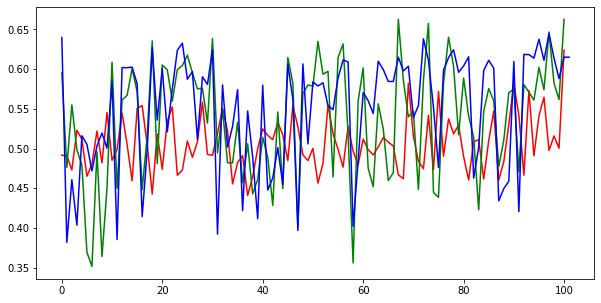

ogbg-ppa
UPFD
SBM-Isolation


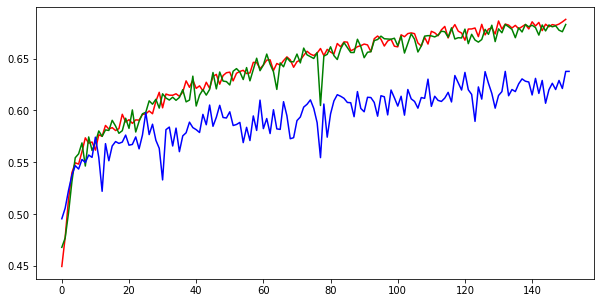

SBM-Environment


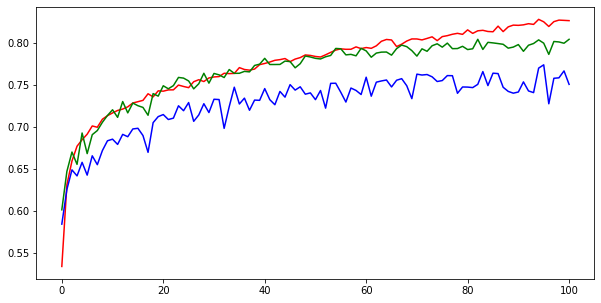

RotatedMNIST


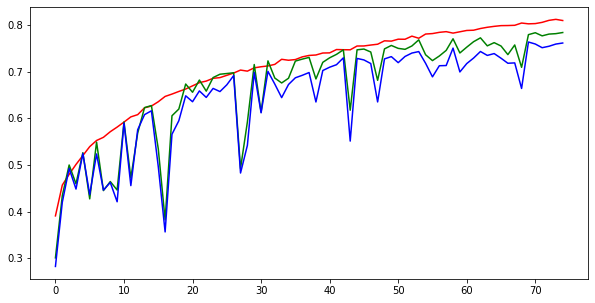

ColoredMNIST


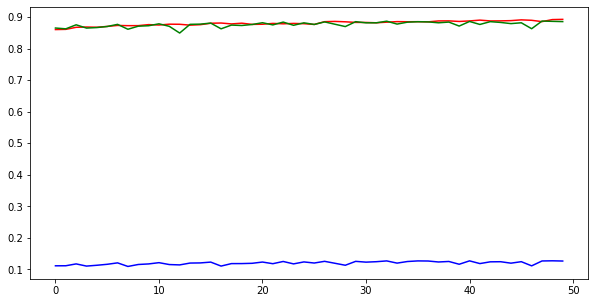

In [5]:
for d in datasets:
    print(d)
    parse('convergence_plot', d=d, a='MLDG', m='gin', para='1.0', exps=exps)

In [19]:
for d in datasets:
    print(d)
    parse('convergence_plot', d=d, a='IRM', m='gin', para='1.0', exps=exps)

ogb-molpcba
ogb-molhiv
ogbg-ppa
UPFD
SBM-Isolation
SBM-Environment
RotatedMNIST
ColoredMNIST


ogb-molpcba
ogb-molhiv
ogbg-ppa
UPFD


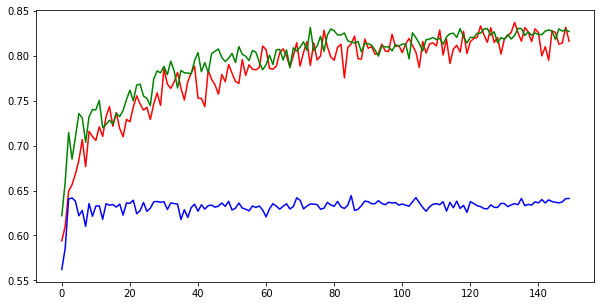

SBM-Isolation


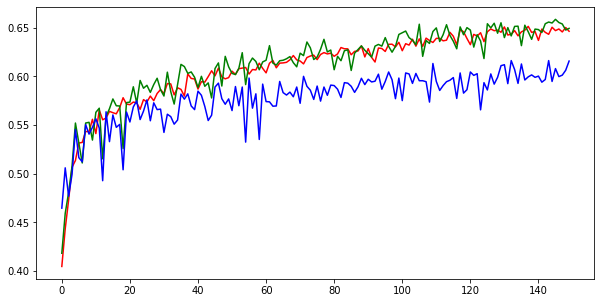

SBM-Environment


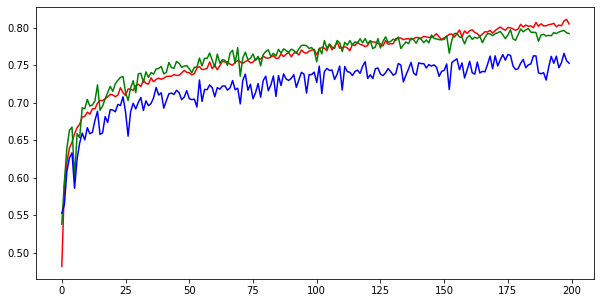

RotatedMNIST


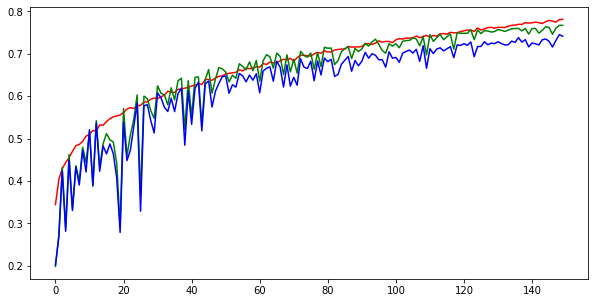

ColoredMNIST


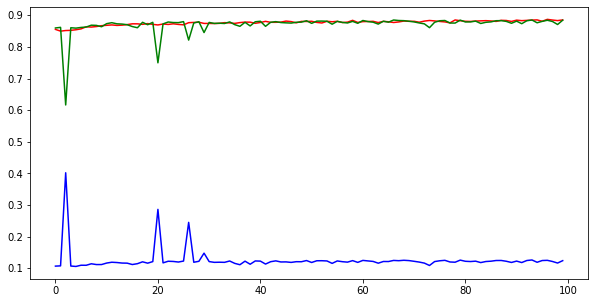

In [31]:
for d in datasets:
    print(d)
    parse('convergence_plot', d=d, a='DANN', m='gin', para='0.1', exps=exps)

ogb-molpcba


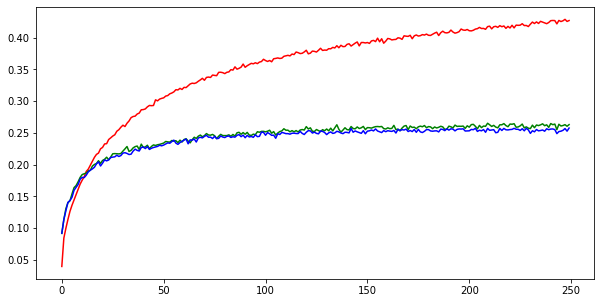

ogb-molhiv


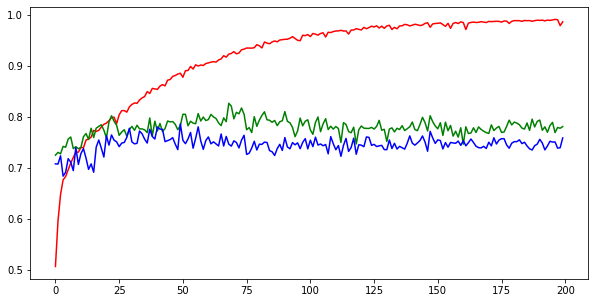

ogbg-ppa


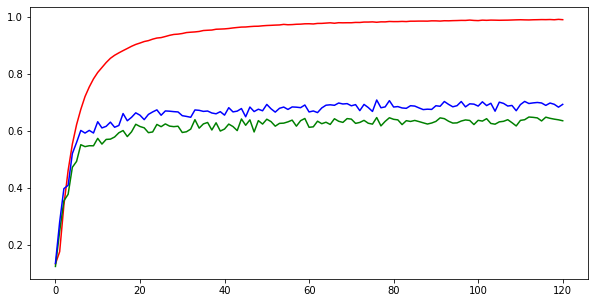

UPFD


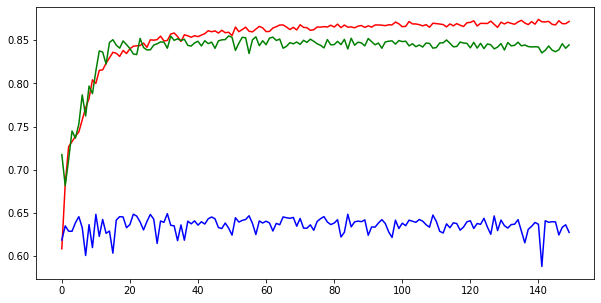

SBM-Isolation


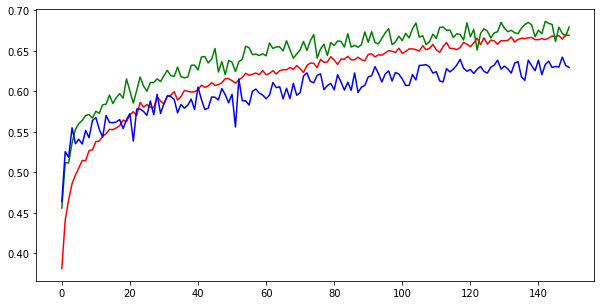

SBM-Environment


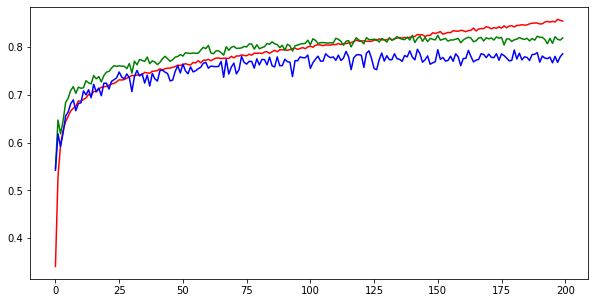

RotatedMNIST


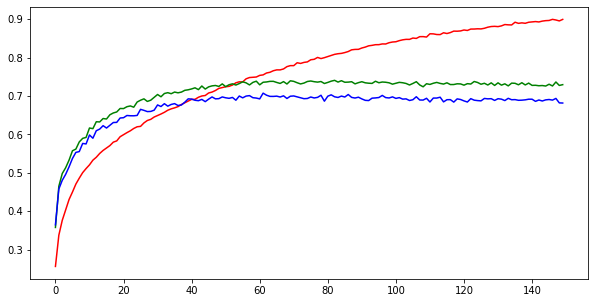

ColoredMNIST


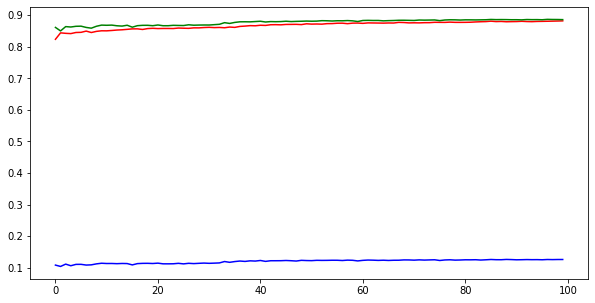

In [29]:
for d in datasets:
    print(d)
    parse('convergence_plot', d=d, a='FLAG', m='gin', para='0.01', exps=exps)